In [0]:
## Survival Analysis using Keras
import pandas as pd
from tensorflow import keras
from keras.initializers import glorot_uniform
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, LSTM
from keras.optimizers import SGD, RMSprop, Adam
from keras.regularizers import l2
import keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from lifelines.utils import concordance_index
import random
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from keras.callbacks import EarlyStopping
import seaborn as sns
import missingno as msno
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import svm

In [2]:
pip install lifelines

     |████████████████████████████████| 389kB 2.7MB/s 


In [0]:
full_data=pd.read_csv("full_dataset.csv")

In [5]:
full_data.isnull().sum()
mis_val_percent = 100 * full_data.isnull().sum() / len(full_data)
mis_val_percent

Patient ID              0.000000
Time of Observation     0.000000
HR                      9.882619
O2Sat                  13.061119
Temp                   66.162697
SBP                    14.576958
MAP                    12.451279
DBP                    31.345887
Resp                   15.354559
EtCO2                  96.286843
BaseExcess             94.579020
HCO3                   95.810618
FiO2                   91.665754
pH                     93.069688
PaCO2                  94.440121
SaO2                   96.549372
AST                    98.377604
BUN                    93.134434
Alkalinephos           98.393194
Calcium                94.116067
Chloride               95.460279
Creatinine             93.904433
Bilirubin_direct       99.807371
Glucose                82.894325
Lactate                97.329872
Magnesium              93.689578
Phosphate              95.986303
Potassium              90.689082
Bilirubin_total        98.509158
TroponinI              99.047745
Hct       

In [6]:
#full_data1=full_data.drop(full_data.columns[mis_val_percent>90])
col=full_data.columns[mis_val_percent>90]
full_data=full_data.drop(col,axis=1)
full_data.columns

Index(['Patient ID', 'Time of Observation', 'HR', 'O2Sat', 'Temp', 'SBP',
       'MAP', 'DBP', 'Resp', 'Glucose', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

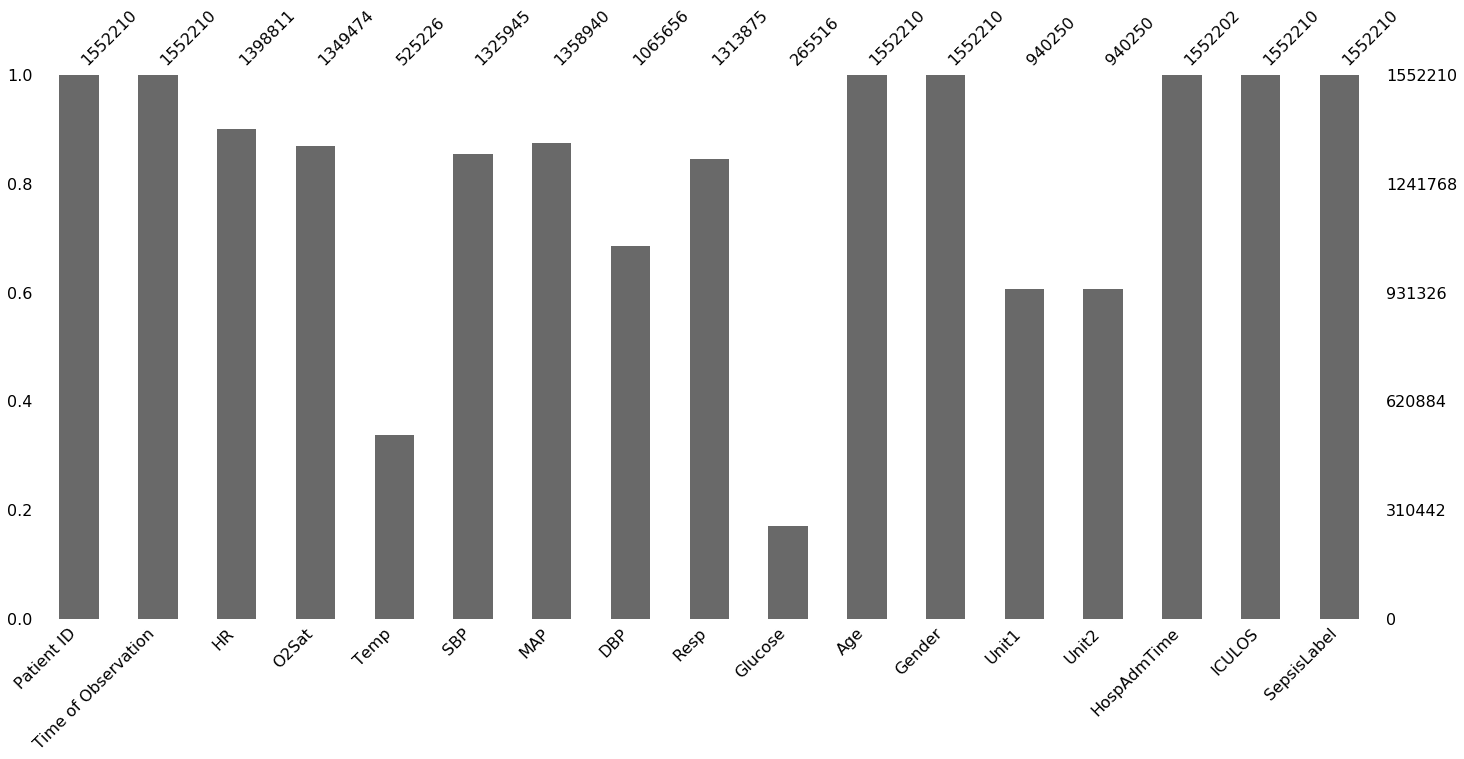

In [7]:
msno.bar(full_data)

In [8]:
full_data.head()

,Patient ID,Time of Observation,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Glucose,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,p000001.psv,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,1,0
1,p000001.psv,1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,83.14,0,NaN,NaN,-0.03,2,0
2,p000001.psv,2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,83.14,0,NaN,NaN,-0.03,3,0
3,p000001.psv,3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,83.14,0,NaN,NaN,-0.03,4,0
4,p000001.psv,4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,83.14,0,NaN,NaN,-0.03,5,0


In [0]:
#full_data['Patient ID'][2]
#df = full_data.set_index(['Patient ID','Time of Observation'])
#df.head()

In [0]:
#sepsis_sum = df['SepsisLabel'].sum(level='Patient ID')
#sepsis_sum


In [10]:
len(full_data['Patient ID'].unique())

40336

In [11]:

sepsis_sum=full_data.groupby(['Patient ID'])['SepsisLabel'].sum()
np.sum(sepsis_sum)

27916

In [12]:
len(sepsis_sum[sepsis_sum > 0])

2932

In [0]:
patient_time = full_data.groupby(['Patient ID'])['SepsisLabel'].count()

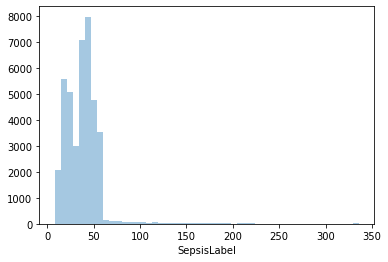

In [14]:
sns.distplot(patient_time, kde=False)

In [15]:
temp = full_data.groupby(['Patient ID'])['SepsisLabel'].sum().reset_index()
sepsis_patients = temp[temp['SepsisLabel'] > 0]['Patient ID']
data= full_data[full_data['Patient ID'].isin(sepsis_patients)]

data.head()

,Patient ID,Time of Observation,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Glucose,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
304,p000009.psv,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.92,1,NaN,NaN,-0.03,1,0
305,p000009.psv,1,117.0,99.0,NaN,116.0,97.0,81.0,20.0,NaN,27.92,1,NaN,NaN,-0.03,2,0
306,p000009.psv,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.0,27.92,1,NaN,NaN,-0.03,3,0
307,p000009.psv,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.5,27.92,1,NaN,NaN,-0.03,4,0
308,p000009.psv,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.0,27.92,1,NaN,NaN,-0.03,5,0


In [0]:
sepsis_time = []
tot_time = []


for pid in sepsis_patients:
    df = data[data['Patient ID']==pid]
    sepsis_time.append(df[df['SepsisLabel']==1]['Time of Observation'].iloc[0])
    tot_time.append(df[df['SepsisLabel']==1]['Time of Observation'][::-1].iloc[0])



In [17]:
df=data[data['Patient ID']=='p000009.psv']
sepsis_time=df[df['SepsisLabel']==1]['Time of Observation'].iloc[0]
tot_time=df[df['SepsisLabel']==1]['Time of Observation'][::-1].iloc[0]

df.iloc[sepsis_time-12:sepsis_time+1,-1]=1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [18]:
df=[]
for pid in sepsis_patients:
    df1=data[data['Patient ID']==pid]
    sepsis_time=df1[df1['SepsisLabel']==1]['Time of Observation'].iloc[0]
    tot_time=df1[df1['SepsisLabel']==1]['Time of Observation'][::-1].iloc[0]
 
    if tot_time>=12:
        df1.iloc[sepsis_time-11:sepsis_time,-1]=1
    else:
        df1.iloc[:sepsis_time,-1]=1
    df.append(df1)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [19]:
sepsis_data=pd.concat(df,axis=0)
sepsis_data.shape

(172410, 17)

In [20]:
sepsis_sum=sepsis_data.groupby(['Patient ID'])['SepsisLabel'].sum()
np.sum(sepsis_sum)

49995

In [21]:
len(sepsis_data['Patient ID'].unique())/5

586.4

In [0]:
sep_idx1=sepsis_data['Patient ID'].unique()[0:586]
sep_idx2=sepsis_data['Patient ID'].unique()[586:586+586]
sep_idx3=sepsis_data['Patient ID'].unique()[586+586:586+586+586]
sep_idx4=sepsis_data['Patient ID'].unique()[586+586+586:586+586+586+586]
sep_idx5=sepsis_data['Patient ID'].unique()[586+586+586+586:]

In [0]:
fold1=sepsis_data[sepsis_data['Patient ID'].isin(sep_idx1)]
fold2=sepsis_data[sepsis_data['Patient ID'].isin(sep_idx2)]
fold3=sepsis_data[sepsis_data['Patient ID'].isin(sep_idx3)]
fold4=sepsis_data[sepsis_data['Patient ID'].isin(sep_idx4)]
fold5=sepsis_data[sepsis_data['Patient ID'].isin(sep_idx5)]

In [24]:
nonsepsis_patients = temp[temp['SepsisLabel']==0]['Patient ID']
nonsepsis_data= full_data[full_data['Patient ID'].isin(nonsepsis_patients)]
nonsepsis_data.head()

,Patient ID,Time of Observation,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Glucose,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,p000001.psv,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,1,0
1,p000001.psv,1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,83.14,0,NaN,NaN,-0.03,2,0
2,p000001.psv,2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,83.14,0,NaN,NaN,-0.03,3,0
3,p000001.psv,3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,83.14,0,NaN,NaN,-0.03,4,0
4,p000001.psv,4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,83.14,0,NaN,NaN,-0.03,5,0


In [25]:
len(nonsepsis_data['Patient ID'].unique())

37404

In [0]:
nonsep_idx1=nonsepsis_data['Patient ID'].unique()[0:7480]
nonsep_idx2=nonsepsis_data['Patient ID'].unique()[7480:7480+7480]
nonsep_idx3=nonsepsis_data['Patient ID'].unique()[7480+7480:7480+7480+7480]
nonsep_idx4=nonsepsis_data['Patient ID'].unique()[7480+7480+7480:7480+7480+7480+7480]
nonsep_idx5=nonsepsis_data['Patient ID'].unique()[7480+7480+7480+7480:]

In [0]:
fold1=fold1.append(nonsepsis_data[nonsepsis_data['Patient ID'].isin(nonsep_idx1)])
fold2=fold2.append(nonsepsis_data[nonsepsis_data['Patient ID'].isin(nonsep_idx2)])
fold3=fold3.append(nonsepsis_data[nonsepsis_data['Patient ID'].isin(nonsep_idx3)])
fold4=fold4.append(nonsepsis_data[nonsepsis_data['Patient ID'].isin(nonsep_idx4)])
fold5=fold5.append(nonsepsis_data[nonsepsis_data['Patient ID'].isin(nonsep_idx5)])

In [28]:
fold5.shape

(311683, 17)

In [0]:
fold1.to_csv('fold1.csv',index=False)
fold2.to_csv('fold2.csv',index=False)
fold3.to_csv('fold3.csv',index=False)
fold4.to_csv('fold4.csv',index=False)
fold5.to_csv('fold5.csv',index=False)

In [32]:
from numpy.random import seed
seed(1234)
from tensorflow import set_random_seed
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
set_random_seed(1234)

fold_index= range(1,6)
remainInd = []
for index in fold_index:
    test_index= index 
    remaining_index= [i  for i in fold_index if index != i ]  
    remainInd.append(remaining_index)
    
    for idx in remainInd:
        val_index=idx[np.random.randint(np.shape(remainInd)[1])]
        train_index= [k for k in idx if k != val_index]
    
    # then train_index = [2, 3, 4]
    
    print('*** Fold', index, '***')
    print('\tVal Index:',val_index)
    print('\tTrain Index:',train_index)
    print('\tTest Index:',test_index)
        
    fold_name = 'fold' + str(val_index) + '.csv'
    print('\t(Val Data: ', fold_name, ')\n')
    val_data = pd.read_csv(fold_name) # Fold_2_df.psv
        
    train_data = pd.read_csv('fold' + str(train_index[0]) + '.csv')
    for i in train_index[1:]:
        train_data = train_data.append(pd.read_csv('fold' + str(i) + '.csv')) 
        
    fold_name1 = 'fold' + str(test_index) + '.csv'
    print('\t(Test Data: ', fold_name1, ')\n')
    test_data = pd.read_csv(fold_name1)
    
    X_train = train_data.drop(['Patient ID','Time of Observation','SepsisLabel' ],axis=1)
    y_train = train_data['SepsisLabel']
        
    X_val = val_data.drop(['Patient ID','Time of Observation','SepsisLabel' ],axis=1)
    y_val = val_data['SepsisLabel']
        
        
    X_test = test_data.drop(['Patient ID','Time of Observation','SepsisLabel' ],axis=1)
    y_test = test_data['SepsisLabel']
    
    #Missing value imputation
    from sklearn.preprocessing import Imputer
    imputer = Imputer()
    X_train = imputer.fit_transform(X_train)
    X_val= imputer.transform(X_val)
    X_test= imputer.transform(X_test)
    # from sklearn.impute import SimpleImputer
    # imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    # X_train = imputer.fit_transform(X_train)
    # X_val= imputer.transform(X_val)
    # X_test= imputer.transform(X_test)

    
    #Normalization
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val= scaler.transform(X_val)
    X_test= scaler.transform(X_test)
       
    seed(1234)
    set_random_seed(1234)

    train_result = []
    valid_result = []
    test_result = []
    
    train_result_auroc = []
    valid_result_auroc = []
    test_result_auroc = [] 
    
    lda=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

    lda.fit(X_train, y_train)
    y_pred_train= lda.predict(X_train)
    y_pred_valid= lda.predict(X_val)
    y_pred_test= lda.predict(X_test)
        
    train_result.append(accuracy_score(y_train,y_pred_train ))
    valid_result.append(accuracy_score(y_val,y_pred_valid ))
    test_result.append(accuracy_score(y_test,y_pred_test ))
    
    train_result_auroc.append(roc_auc_score(y_train,y_pred_train ))
    valid_result_auroc.append(roc_auc_score(y_val,y_pred_valid ))
    test_result_auroc.append(roc_auc_score(y_test,y_pred_test ))
    
    
    lda_value={'Train_result':train_result,'Valid_result':valid_result, 'Test_result':test_result, 'Train_result_auroc':train_result_auroc,'Valid_result_auroc':valid_result_auroc,'Test_result_auroc':test_result_auroc}
    lda_values=pd.DataFrame(lda_value)
    lda_values
    
    
    
    
 

*** Fold 1 ***
	Val Index: 5
	Train Index: [2, 3, 4]
	Test Index: 1
	(Val Data:  fold5.csv )

	(Test Data:  fold1.csv )



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


*** Fold 2 ***
	Val Index: 5
	Train Index: [1, 3, 4]
	Test Index: 2
	(Val Data:  fold5.csv )

	(Test Data:  fold2.csv )



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


*** Fold 3 ***
	Val Index: 4
	Train Index: [1, 2, 5]
	Test Index: 3
	(Val Data:  fold4.csv )

	(Test Data:  fold3.csv )



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


*** Fold 4 ***
	Val Index: 2
	Train Index: [1, 3, 5]
	Test Index: 4
	(Val Data:  fold2.csv )

	(Test Data:  fold4.csv )



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


*** Fold 5 ***
	Val Index: 1
	Train Index: [2, 3, 4]
	Test Index: 5
	(Val Data:  fold1.csv )

	(Test Data:  fold5.csv )



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [0]:
    import matplotlib.pyplot as plt
 

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()  

In [0]:
inputs = keras.Input(shape=(X_train.shape[1],), name='features')
    x = layers.Dense(200, activation='relu', name='dense_1')(inputs)
    x = layers.Dense(100, activation='relu', name='dense_2')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(50, activation='relu', name='dense_3')(x)
    x = layers.Dense(25, activation='relu', name='dense_4')(x)
    
    outputs = layers.Dense(1, activation='sigmoid', name='predictions')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

 
    
    adam=Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    sgd = keras.optimizers.SGD(lr=0.00001, decay=0.01, momentum=0.9, nesterov=True)
    rmsprop = RMSprop(lr=1e-5, rho=0.9, epsilon=1e-8)
    
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
   
    history=model.fit(X_train, y_train, batch_size=64, epochs=1, validation_data=(X_val, y_val), shuffle=False)
     
    # Evaluate the model on the test data using `evaluate`
    print('\n# Evaluate on test data')
    results = model.evaluate(X_test, y_test, batch_size=128)
    print('test loss, test acc:', results)    
    